In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Flatten, Dropout
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [3]:
# WISDM

columns_wisdm = ['user', 'activity', 'time', 'x_axis', 'y_axis', 'z_axis']
data = pd.read_csv('/content/drive/MyDrive/MCA Main Project/WISDM_ar_v1.1_raw.txt', header=None, names = columns_wisdm)
data = data.dropna()
data.head()

data = data.drop(['user','time'], axis = 1).copy()
data

,activity,x_axis,y_axis,z_axis
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...
1098199,Sitting,9.000000,-1.570000,1.690000
1098200,Sitting,9.040000,-1.460000,1.730000
1098201,Sitting,9.080000,-1.380000,1.690000
1098202,Sitting,9.000000,-1.460000,1.730000


In [4]:
# HAPT

columns = ['activity', 'x_axis', 'y_axis', 'z_axis']
df = pd.read_csv('/content/drive/MyDrive/MCA Main Project/HAPT RawExtracted/TrainingData/Train.txt', header=None, sep = ' ',names = columns)
df = df.dropna()
df.head()

# Applying the condition
df['activity'].mask(df['activity'] == 1, 'Walking', inplace=True)
df['activity'].mask(df['activity'] == 2, 'Upstairs', inplace=True)
df['activity'].mask(df['activity'] == 3, 'Downstairs', inplace=True)
df['activity'].mask(df['activity'] == 4, 'Sitting', inplace=True)
df['activity'].mask(df['activity'] == 5, 'Standing', inplace=True)
df['activity'].mask(df['activity'] == 6, 'Laying', inplace=True)

df

df = df.append(data)

# removing laying activity
df = df[df['activity'] != 'Laying']

df

,activity,x_axis,y_axis,z_axis
0,Walking,1.420833,-0.340278,-0.125000
1,Walking,1.002778,-0.204167,-0.108333
2,Walking,0.683333,-0.061111,-0.108333
3,Walking,0.733333,-0.083333,-0.120833
4,Walking,0.956944,-0.263889,-0.137500
...,...,...,...,...
1098199,Sitting,9.000000,-1.570000,1.690000
1098200,Sitting,9.040000,-1.460000,1.730000
1098201,Sitting,9.080000,-1.380000,1.690000
1098202,Sitting,9.000000,-1.460000,1.730000


In [5]:
df.head(11)

,activity,x_axis,y_axis,z_axis
0,Walking,1.420833,-0.340278,-0.125000
1,Walking,1.002778,-0.204167,-0.108333
2,Walking,0.683333,-0.061111,-0.108333
3,Walking,0.733333,-0.083333,-0.120833
4,Walking,0.956944,-0.263889,-0.137500
5,Walking,1.050000,-0.402778,-0.144444
6,Walking,1.013889,-0.415278,-0.104167
7,Walking,0.950000,-0.393056,-0.105556
8,Walking,0.950000,-0.359722,-0.102778
9,Walking,0.952778,-0.315278,-0.086111


In [6]:
# removing null values

df = df.dropna()
df.shape

(1210045, 4)

In [10]:
df.head()

,activity,x_axis,y_axis,z_axis
0,Walking,1.420833,-0.340278,-0.125000
1,Walking,1.002778,-0.204167,-0.108333
2,Walking,0.683333,-0.061111,-0.108333
3,Walking,0.733333,-0.083333,-0.120833
4,Walking,0.956944,-0.263889,-0.137500


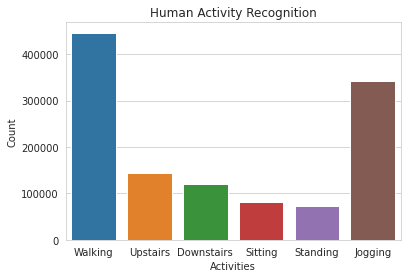

In [11]:
sns.set_style("whitegrid")
sns.countplot(x = 'activity', data = df)
plt.title('Human Activity Recognition')
plt.xlabel('Activities')
plt.ylabel('Count')
plt.show()

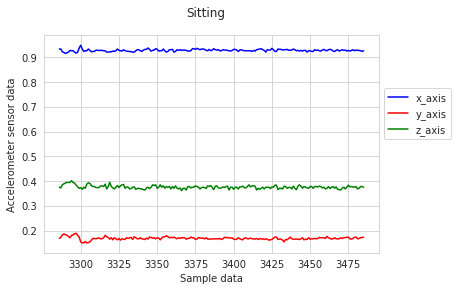

In [12]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:200]
    axis = data["x_axis"].plot(subplots=True, 
                     title=activity,color="b")
    axis = data["y_axis"].plot(subplots=True, 
                 title=activity,color="r")
    axis = data["z_axis"].plot(subplots=True, 
             title=activity,color="g")
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

plt.xlabel('Sample data')
plt.ylabel('Accelerometer sensor data')
plot_activity('Sitting', df)

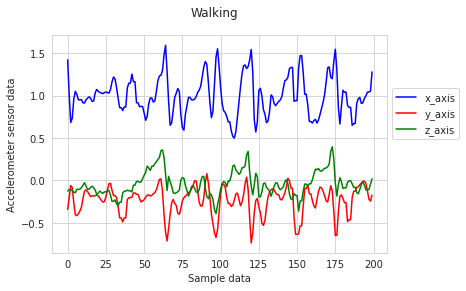

In [13]:
plt.xlabel('Sample data')
plt.ylabel('Accelerometer sensor data')
plot_activity("Walking", df)

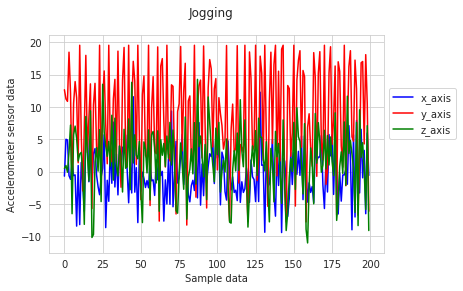

In [14]:
plt.xlabel('Sample data')
plt.ylabel('Accelerometer sensor data')
plot_activity("Jogging", df)

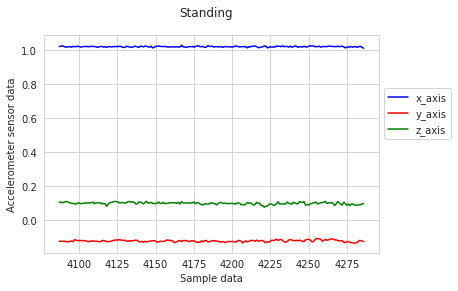

In [15]:
plt.xlabel('Sample data')
plt.ylabel('Accelerometer sensor data')
plot_activity("Standing", df)

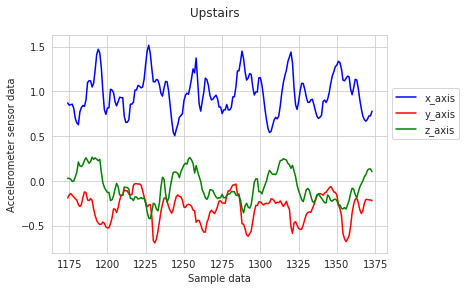

In [16]:
plt.xlabel('Sample data')
plt.ylabel('Accelerometer sensor data')
plot_activity("Upstairs", df)

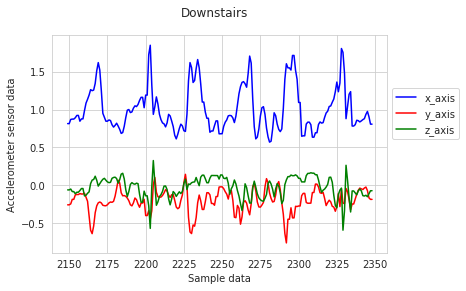

In [17]:
plt.xlabel('Sample data')
plt.ylabel('Accelerometer sensor data')
plot_activity("Downstairs", df)

In [19]:
random_seed = 42
n_time_steps = 50
n_features = 3
step = 10
n_classes = 6
n_epochs = 100
batch_size = 128
learning_rate = 0.0025
l2_loss = 0.0015

In [20]:
segments = []
labels = []

for i in range(0, df.shape[0] - n_time_steps, step):
    
    xs = df['x_axis'].values[i: i + 50]
    ys = df['y_axis'].values[i: i + 50]
    zs = df['z_axis'].values[i: i + 50]
    
    label = stats.mode(df['activity'][i: i + 50])[0][0]
    
    segments.append([xs,ys,zs])
    
    labels.append(label)

# reshape the segments which is(list of arrays) to a list

reshaped_segments = np.asarray(segments, dtype = np.float32).reshape(-1, n_time_steps, n_features)

labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)

In [21]:
reshaped_segments.shape

(121000, 50, 3)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_segments, labels, test_size=0.2, random_state=random_seed)

In [23]:
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Building Model Architecture

model = Sequential()

# LSTM layer

model.add(LSTM(units=128, input_shape=(X_train.shape[1],X_train.shape[2]), name = 'lstm_1'))

# Dropout layer

model.add(Dropout(0.5))

# Dense layer with ReLu

model.add(Dense(units=64, activation='relu', name = 'dense_1'))

# Softmax layer

model.add(Dense(y_train.shape[1], activation='softmax', name = 'output'))

# Compile model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 output (Dense)              (None, 6)                 390       
                                                                 
Total params: 76,230
Trainable params: 76,230
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = model.fit(X_train, y_train, epochs=n_epochs, validation_split=0.2, batch_size=batch_size, verbose=1, callbacks = [callback])

Epoch 1/100
605/605 [==============================] - 13s 8ms/step - loss: 0.6357 - accuracy: 0.7617 - val_loss: 0.4725 - val_accuracy: 0.8186
Epoch 2/100
605/605 [==============================] - 4s 7ms/step - loss: 0.4400 - accuracy: 0.8282 - val_loss: 0.3742 - val_accuracy: 0.8517
Epoch 3/100
605/605 [==============================] - 4s 7ms/step - loss: 0.3562 - accuracy: 0.8637 - val_loss: 0.3005 - val_accuracy: 0.8857
Epoch 4/100
605/605 [==============================] - 6s 9ms/step - loss: 0.2739 - accuracy: 0.9010 - val_loss: 0.2336 - val_accuracy: 0.9146
Epoch 5/100
605/605 [==============================] - 9s 15ms/step - loss: 0.2312 - accuracy: 0.9182 - val_loss: 0.2146 - val_accuracy: 0.9263
Epoch 6/100
605/605 [==============================] - 8s 13ms/step - loss: 0.2044 - accuracy: 0.9285 - val_loss: 0.1884 - val_accuracy: 0.9350
Epoch 7/100
605/605 [==============================] - 5s 8ms/step - loss: 0.1767 - accuracy: 0.9392 - val_loss: 0.1578 - val_accuracy: 0.9

In [26]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size,verbose=1)
print("Test Accuracy :", accuracy)
print("Test Loss :", loss)

190/190 [==============================] - 1s 5ms/step - loss: 0.1320 - accuracy: 0.9551
Test Accuracy : 0.9550826549530029
Test Loss : 0.1319613754749298


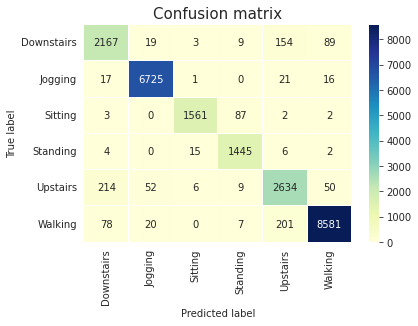

In [27]:
# Confusion matrix
import sklearn.metrics as metrics

predictions = model.predict(X_test)
class_labels = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)
sns.heatmap(confusion_matrix, xticklabels=class_labels, yticklabels=class_labels, annot=True,linewidths=0.1,fmt='d', cmap='YlGnBu')
plt.title("Confusion matrix", fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [28]:
# Classification report

class_labels = ['Downstairs','Jogging','Sitting','Standing','Upstairs','Walking']
predictions = model.predict(X_test)
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
classification_report = metrics.classification_report(max_test, max_predictions, target_names = class_labels)
print(classification_report)

              precision    recall  f1-score   support

  Downstairs       0.87      0.89      0.88      2441
     Jogging       0.99      0.99      0.99      6780
     Sitting       0.98      0.94      0.96      1655
    Standing       0.93      0.98      0.95      1472
    Upstairs       0.87      0.89      0.88      2965
     Walking       0.98      0.97      0.97      8887

    accuracy                           0.96     24200
   macro avg       0.94      0.94      0.94     24200
weighted avg       0.96      0.96      0.96     24200



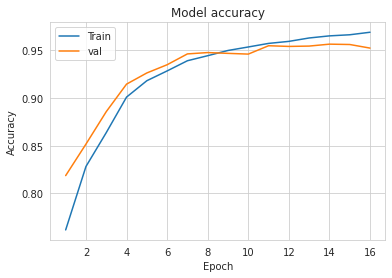

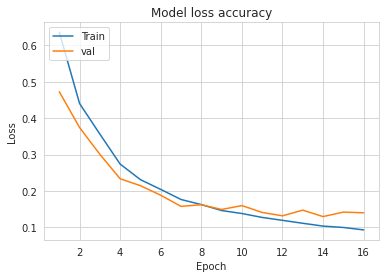

In [29]:
# Learning curves

def plot_learningCurve(history,epochs):

  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train','val'],loc='upper left')
  plt.show()

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss accuracy')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train','val'],loc='upper left')
  plt.show()

plot_learningCurve(history,16)

In [30]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import numpy as np
import tensorflow as tf
#path of the directory where you want to save your model
frozen_out_path = ''
# name of the .pb file
frozen_graph_filename = "frozen_graph"
# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))
# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()
layers = [op.name for op in frozen_func.graph.get_operations()]
print("-" * 60)
print("Frozen model layers: ")
for layer in layers:
    print(layer)
print("-" * 60)
print("Frozen model inputs: ")
print(frozen_func.inputs)
print("Frozen model outputs: ")
print(frozen_func.outputs)
# Save frozen graph to disk
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pb",
                  as_text=False)
# Save its text representation
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir=frozen_out_path,
                  name=f"{frozen_graph_filename}.pbtxt",
                  as_text=True)

------------------------------------------------------------
Frozen model layers: 
x
unused_control_flow_input
sequential/lstm_1/PartitionedCall/while/body/_12/while/Sigmoid_1
sequential/lstm_1/zeros_1/packed/1
unused_control_flow_input_1
sequential/lstm_1/zeros_1/packed
sequential/lstm_1/zeros_1/Const
sequential/lstm_1/zeros_1
Func/sequential/lstm_1/PartitionedCall/input/_2
sequential/lstm_1/PartitionedCall/while/enter/_18
unused_control_flow_input_2
sequential/lstm_1/PartitionedCall/while/body/_12/while/Identity_5
Func/sequential/lstm_1/PartitionedCall/while/body/_12/output/_101
sequential/lstm_1/PartitionedCall/while/next_iteration/_65
sequential/lstm_1/PartitionedCall/while/merge/_29
unused_control_flow_input_3
sequential/lstm_1/PartitionedCall/while/Func/sequential/lstm_1/PartitionedCall/input/_2_switch/_41
Func/sequential/lstm_1/PartitionedCall/while/body/_12/input/_90
sequential/lstm_1/PartitionedCall/while/body/_12/while/mul
unused_control_flow_input_4
sequential/lstm_1/Partiti

'frozen_graph.pbtxt'